In [ ]:
!pip install tensorflow

In [ ]:
pip install --upgrade "jax[cuda]"

In [1]:
%load_ext autoreload
%autoreload 2

## Testing polynomial trajectory generation

/home/anusha/.local/lib/python3.8/site-packages/jax/_src/api_util.py:165: SyntaxWarning: Jitted function has static_argnums=(0, 1, 9), but only accepts 8 positional arguments. This warning will be replaced by an error after 2022-08-20 at the earliest.
  warnings.warn(f"Jitted function has {argnums_name}={argnums}, "


(101, 3)


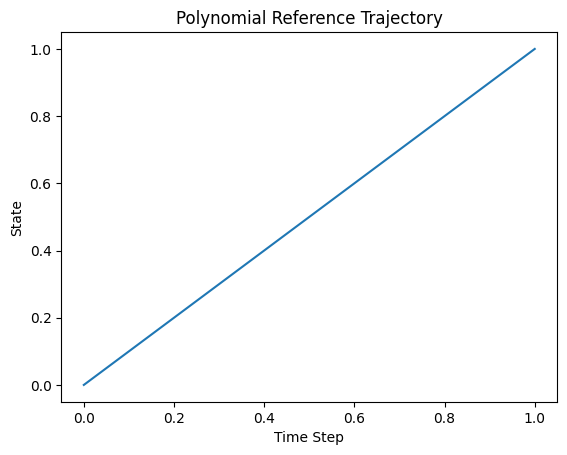

In [2]:
from generate_data import generate_polynomial_trajectory
import numpy as np
import matplotlib.pyplot as plt

start = np.zeros(3)
end = np.ones(3)
T = 101
order = 2

trajectory = generate_polynomial_trajectory(start, end, T, order)

print(trajectory.shape)

# Plot the results
plt.plot(trajectory[:, 0], trajectory[:, 1])
plt.title('Polynomial Reference Trajectory')
plt.xlabel('Time Step')
plt.ylabel('State')
plt.show()

## Data generation

In [24]:
from generate_data import gen_uni_training_data, ILQR, unicycle, save_object, unicycle_K
import jax.numpy as onp

# F = np.array([[np.cos(theta), 0], [np.sin(theta), 0], [0, 1]])
# Kp = 5 * np.array([[2, 1, 0], [0, 1, 3]])
# Kd = np.linalg.pinv(F)

uni_ilqr1 = ILQR(unicycle_K, maxiter=1000)
num_iter = 7
xtraj, rtraj, rdottraj, costs = gen_uni_training_data(uni_ilqr1, num_iter, 6, 3)

# Save as pickle file
save_object([xtraj, rtraj, rdottraj, costs], 'data/uni_train-test.pkl')

[2.6511562 2.2899487 1.6680541 2.423351  2.43218   1.8151464 2.4328427
 2.556587  1.1413331 1.7102478 1.5143092 1.3112772 1.2851481 2.7114828
 0.        0.        0.        0.        0.        0.        0.       ]
[[2.6511562 2.556587  0.       ]
 [2.2899487 1.1413331 0.       ]
 [1.6680541 1.7102478 0.       ]
 [2.423351  1.5143092 0.       ]
 [2.43218   1.3112772 0.       ]
 [1.8151464 1.2851481 0.       ]
 [2.4328427 2.7114828 0.       ]]
[[0.01216197 1.1993573  2.9119067 ]
 [0.9314432  0.45903587 0.73453975]
 [0.45849657 1.566077   0.76147133]
 [1.5071261  1.6157954  1.1956209 ]
 [0.3657341  1.1850812  2.9908745 ]
 [1.9784462  0.8347266  1.0607572 ]
 [1.4012794  0.94467163 0.08098228]]


/home/anusha/.local/lib/python3.8/site-packages/trajax/tvlqr.py:98: FutureWarning: The sym_pos argument to solve() is deprecated and will be removed in a future JAX release. Use assume_a='pos' instead.
  K = -sp.linalg.solve(G_, H, sym_pos=True)
/home/anusha/.local/lib/python3.8/site-packages/trajax/tvlqr.py:99: FutureWarning: The sym_pos argument to solve() is deprecated and will be removed in a future JAX release. Use assume_a='pos' instead.
  k = -sp.linalg.solve(G_, h, sym_pos=True)


1
0.13023445
6.833672
3
0.044021565
4.971573
5
0.0831688
4.910218
7
0.12047702
6.0992374
9
0.25506845
5.834427
11
0.19457471
5.069097
13
0.22746257
6.931517


## Load data

In [2]:
from helper_functions import compute_tracking_cost
from mlp_jax import MLP
from generate_data import load_object
from model_learning import TrajDataset, train_model, eval_model, numpy_collate, save_checkpoint, restore_checkpoint
import numpy as np


file_path = r"/home/anusha/Research/Layered-architecture-quadrotor-control/Simulations/data/uni_train-nonoise1.pkl"
unicycle_data = load_object(file_path)

actual_traj = np.vstack(unicycle_data[0])
ref_traj = np.vstack(unicycle_data[1])
rdot_traj = np.vstack(unicycle_data[2])
print(actual_traj.shape)
print(ref_traj.shape)
print(rdot_traj.shape)

/home/anusha/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/anusha/.local/lib/python3.8/site-packages/jax/_src/api_util.py:165: SyntaxWarning: Jitted function has static_argnums=(0, 1, 9), but only accepts 8 positional arguments. This warning will be replaced by an error after 2022-08-20 at the earliest.
  warnings.warn(f"Jitted function has {argnums_name}={argnums}, "
2023-02-22 22:34:36.614306: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/anusha/Research/ws_kr/devel/lib:/opt/ros/noetic/lib
2023-02-22 22:34:36.614355: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not

(770, 3)
(770, 3)
(770, 3)


## Adding noise to trajectories

In [23]:
from generate_data import forward_simulate
from helper_functions import compute_rdot
import jax

noise_level = [0.0001]
num_iter = 5

N = 101

cycles = 1 # how many sine cycles
resolution = 25 # how many datapoints to generate

length = np.pi * 2 * cycles

for i in range(len(noise_level)):
    for j in range(num_iter):
        my_wave = np.sin(np.arange(0, length, length / N))
        
        noisy_ref = np.zeros(shape=(N, 3))
        noisy_ref[:, 0] = ref_traj[j*N:(j+1)*N, 0] + noise_level[i] * my_wave
        noisy_ref[:, 1:3] = ref_traj[j*N:(j+1)*N, 1:3]
        ref_traj = np.vstack([ref_traj, noisy_ref])
        cost, act = forward_simulate(noisy_ref[0, :], noisy_ref, N)
        actual_traj = np.vstack([actual_traj, act])
        rdot = compute_rdot(noisy_ref, 0.01)
        rdot_traj = np.vstack([rdot_traj, rdot])
        
        noise = np.random.normal(0, noise_level[i], (N, 2))
        
        noisy_ref = np.zeros(shape=(N, 3))
        noisy_ref[:, 0] = ref_traj[j*N:(j+1)*N, 0] + noise[:, 0]
        noisy_ref[:, 1:3] = ref_traj[j*N:(j+1)*N, 1:3]
        ref_traj = np.vstack([ref_traj, noisy_ref])
        cost, act = forward_simulate(noisy_ref[0, :], noisy_ref, N)
        actual_traj = np.vstack([actual_traj, act])
        rdot = compute_rdot(noisy_ref, 0.01)
        rdot_traj = np.vstack([rdot_traj, rdot])
        
        

In [24]:
print(actual_traj.shape)
print(ref_traj.shape)
print(rdot_traj.shape)

(6060, 3)
(6060, 3)
(6060, 3)


## Look at trajectories

In [3]:
%matplotlib notebook

In [5]:
def animate(i):
    line.set_ydata(actual_traj[i, 1])  # update the data.
    return line,

<IPython.core.display.Javascript object>


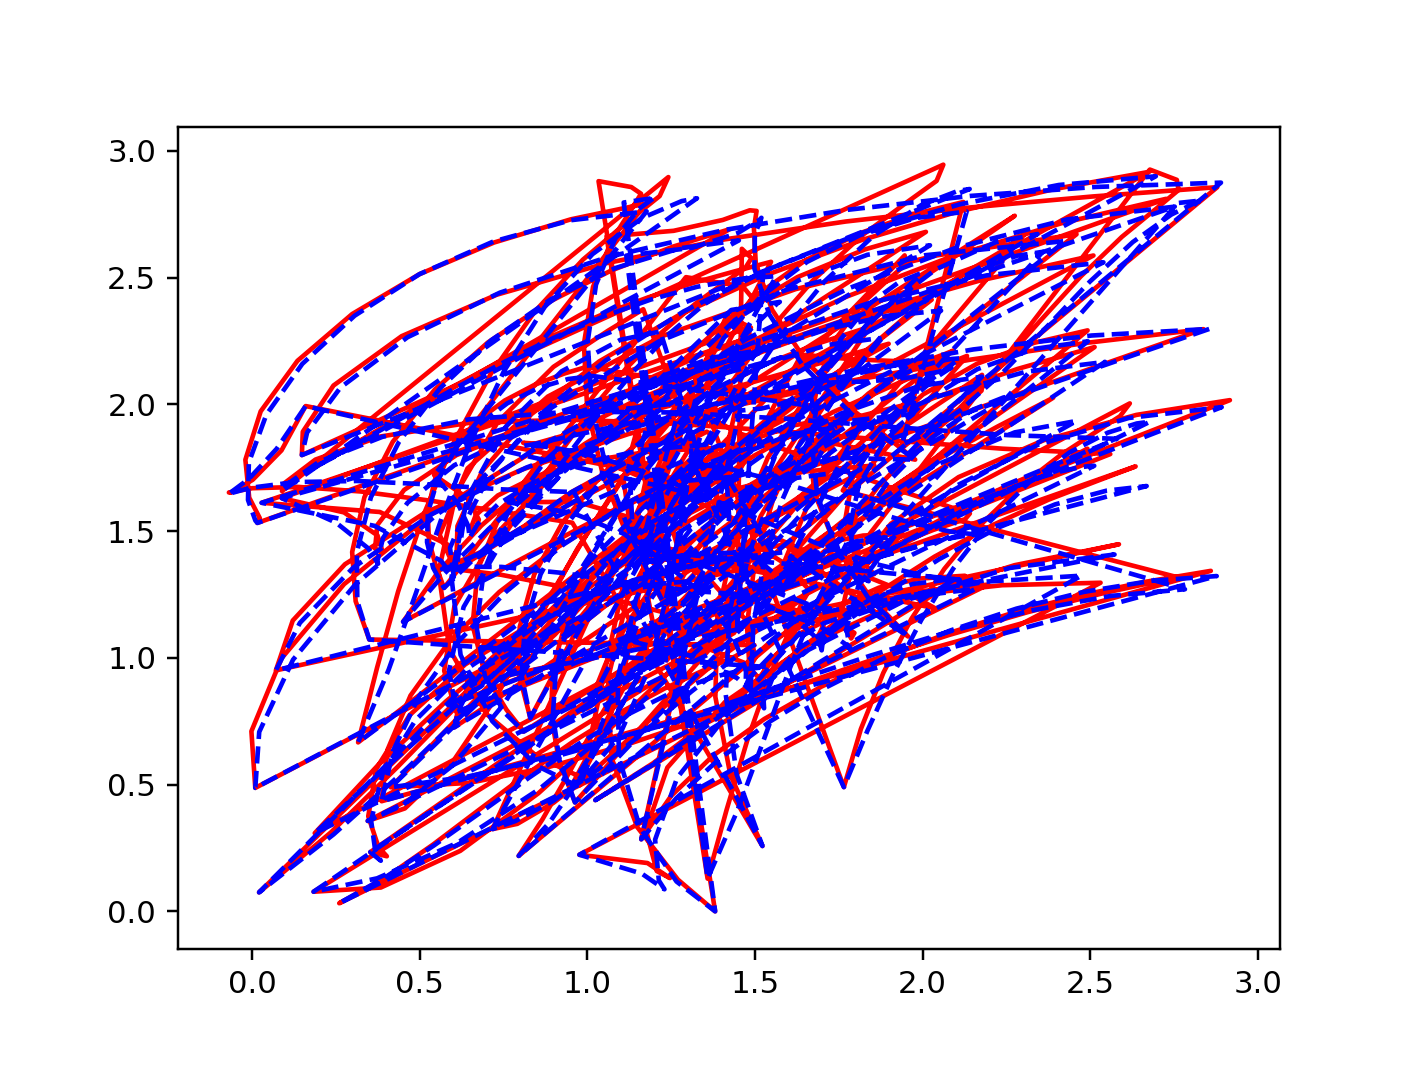

In [4]:
import matplotlib.pyplot as plt

plt.figure()
Tstart = 0
Tend = 770


plt.plot(ref_traj[Tstart:Tend, 0], ref_traj[Tstart:Tend, 1], 'r-', 
         actual_traj[Tstart:Tend, 0], actual_traj[Tstart:Tend, 1], 'b--')

In [ ]:
plt.figure()
Tstart = 0
Tend = 6006
plt.plot(ref_traj[Tstart:Tend, 2], 'r-', 
         actual_traj[Tstart:Tend, 2], 'b--')

## Prepare data with augmented states and compute cost

In [5]:
import jax

N = 10
q = 2
p = 3 + 3*N
traj_len = ref_traj.shape[0]
horizon = 11
num_iter = int(traj_len/horizon)
# num_iter = 50

# ref_chunks = np.vstack([ref_traj[i*100+5:(i+1)*100-5, :] for i in range(0, len(ref_traj))])
# actual_chunks = np.vstack([actual_traj[i*101+5:(i+1)*101-6, :] for i in range(0, len(actual_traj))])

# Kp = 50 * np.array([[2, 0, 0], [0, 1, 0]])
Kp = 5 * np.array([[2, 1, 0], [0, 1, 3]])
# key = jax.random.PRNGKey(793)
# Kd = 50 * jax.random.uniform(key=key, shape=(2, 3))

cost_traj, input_traj = compute_tracking_cost(ref_traj, actual_traj, rdot_traj, Kp, N, horizon, 0.5)

aug_state = []
for i in range(num_iter):
    r0 = ref_traj[i*horizon:(i+1)*horizon, :]
    r0 = np.append(r0, r0[-1, :] * np.ones((N-1, 3)))
    r0 = np.reshape(r0, (horizon+N-1, 3))
    act = actual_traj[i*horizon:(i+1)*horizon, :]
    act = np.append(act, act[-1, :] * np.ones((N-1, 3)))
    act = np.reshape(act, (horizon+N-1, 3))
    for j in range(horizon-N):
        aug_state.append(np.append(act[j, :], r0[j:j+N, :]))
# aug_state = [np.append(actual_traj[r, :], ref_traj[r:r+N, :]) for r in range(num_iter)]
aug_state = np.array(aug_state)
print(aug_state.shape)

Tstart=0
Tend=aug_state.shape[0]

dataset = TrajDataset(aug_state[Tstart:Tend-1, :].astype('float64'), input_traj[Tstart:Tend-1, :].astype('float64'),
                               cost_traj[Tstart:Tend-1, None].astype('float64'), aug_state[Tstart+1:Tend, :].astype('float64'))

770
(70, 33)


<IPython.core.display.Javascript object>


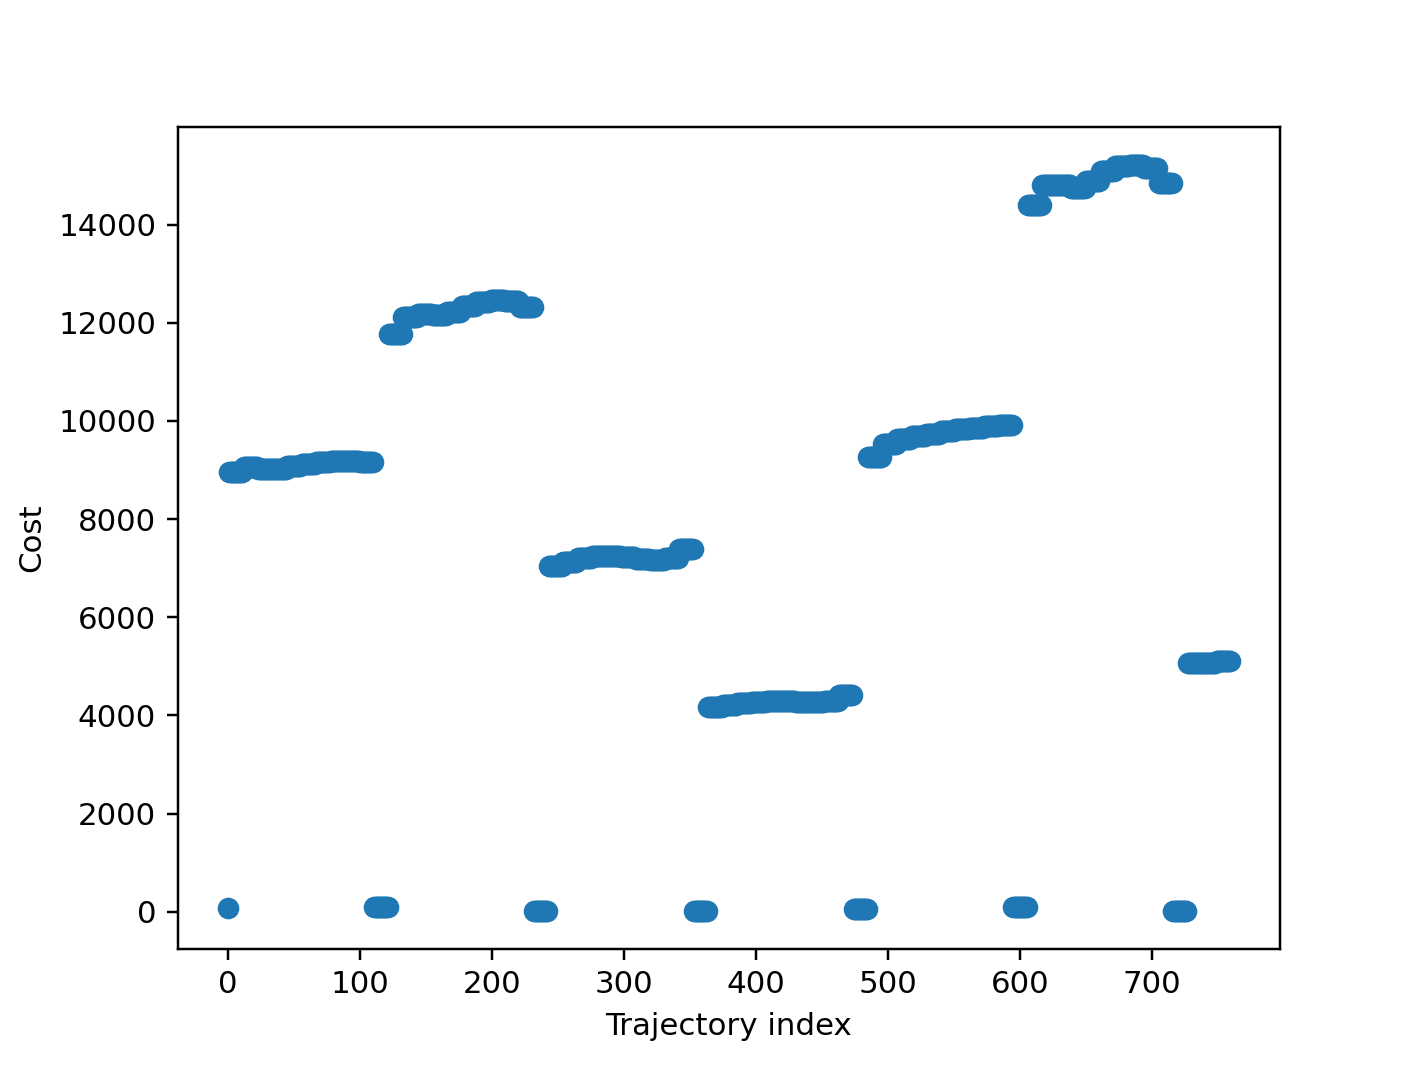

Text(0, 0.5, 'Cost')

In [6]:
plt.figure()
plt.scatter(range(len(cost_traj)), np.exp(cost_traj))
plt.xlabel("Trajectory index")
plt.ylabel("Cost")

<IPython.core.display.Javascript object>


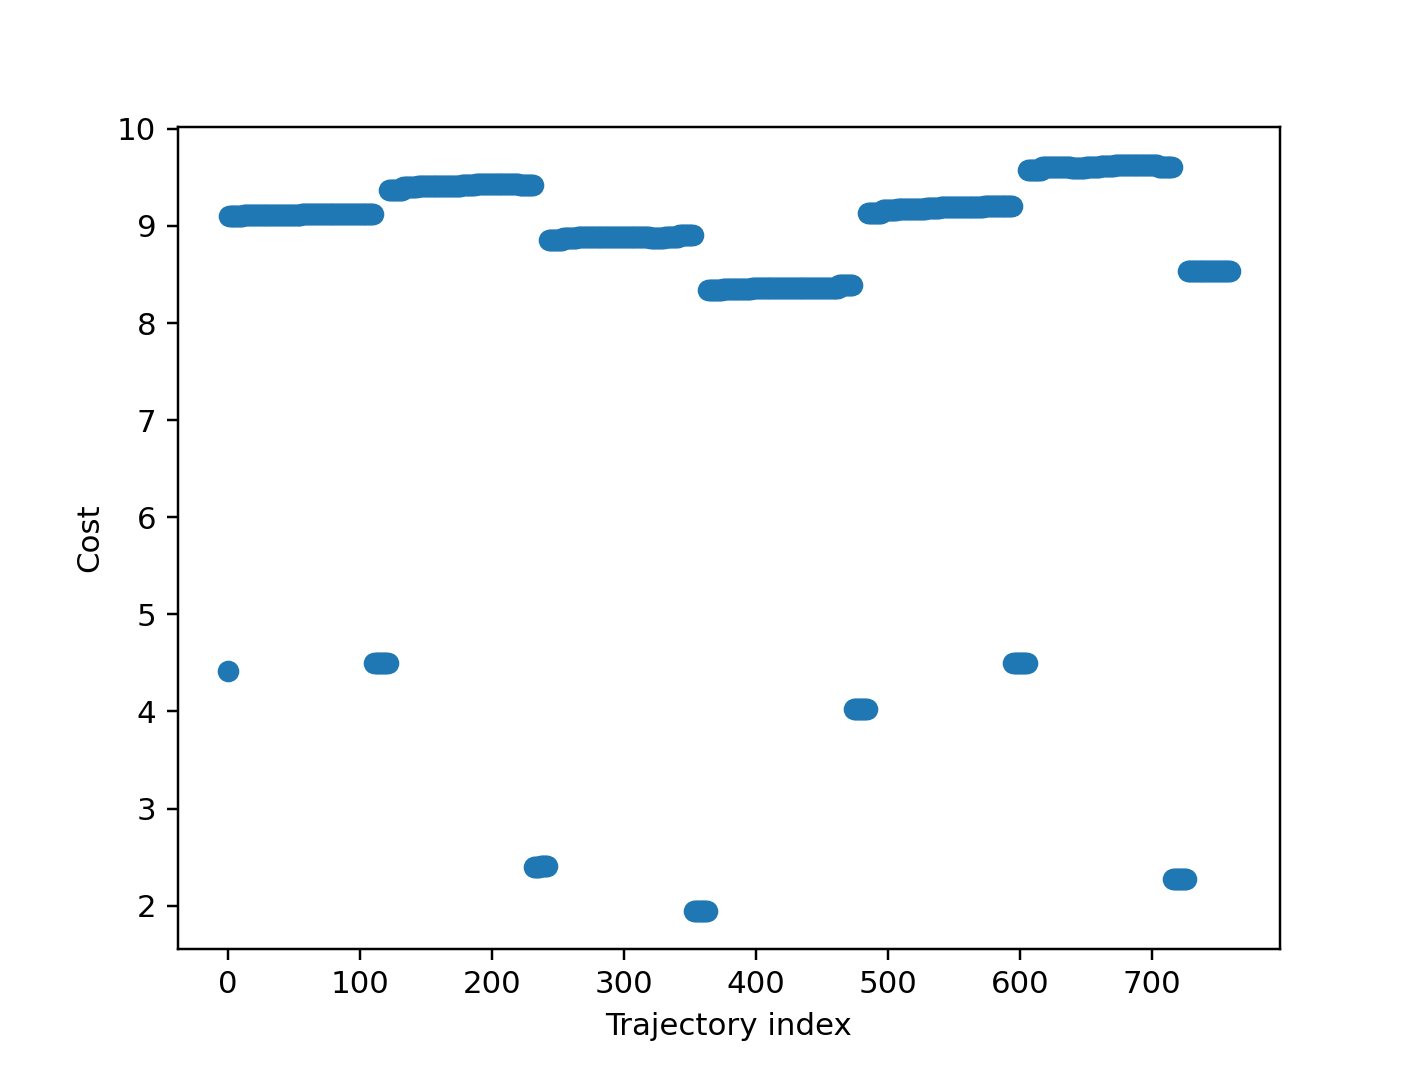

Text(0, 0.5, 'Cost')

In [7]:
plt.figure()
plt.scatter(range(len(cost_traj)), cost_traj)
plt.xlabel("Trajectory index")
plt.ylabel("Cost")

## Define model parameters and train

In [8]:
# Load model parameters using yaml file
import ruamel.yaml as yaml

with open(r"/home/anusha/Research/Layered-architecture-quadrotor-control/Simulations/data/params.yaml") as f:
        yaml_data = yaml.load(f, Loader=yaml.RoundTripLoader)

num_hidden = yaml_data['num_hidden']
batch_size = yaml_data['batch_size']
learning_rate = yaml_data['learning_rate']
num_epochs = yaml_data['num_epochs']
model_save = yaml_data['save_path']

In [9]:
model = MLP(num_hidden=num_hidden, num_outputs=1)
# Printing the model shows its attributes
print(model)

MLP(
    # attributes
    num_hidden = [500, 400, 200]
    num_outputs = 1
)


In [10]:
rng = jax.random.PRNGKey(427)
rng, inp_rng, init_rng = jax.random.split(rng, 3)
inp = jax.random.normal(inp_rng, (batch_size, p))  # Batch size 64, input size p
# Initialize the model
params = model.init(init_rng, inp)

In [10]:
# Run only if error in next cell
try:
    import optax
except ModuleNotFoundError: 
    !pip install --quiet optax
    import optax 

In [11]:
import optax # Run previous cell if optax not found
# Input to the optimizer are optimizer settings like learning rate
optimizer = optax.sgd(learning_rate=learning_rate, momentum=0.9)

In [12]:
from flax.training import train_state

model_state = train_state.TrainState.create(apply_fn=model.apply,
                                            params=params,
                                            tx=optimizer)

In [13]:
import torch.utils.data as data

train_data_loader = data.DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=numpy_collate)
trained_model_state = train_model(model_state, train_data_loader, num_epochs=num_epochs)

  0%|                                                                                                                                                                             | 0/1000 [00:00<?, ?it/s]

Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=0/1)>
Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=0/1)>


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 356.78it/s]


In [14]:
eval_model(trained_model_state, train_data_loader, batch_size)

Loss of the model: 0.12


In [19]:
!pip install tensorboard

In [15]:
trained_model = model.bind(trained_model_state.params)

### Save model

In [82]:
save_checkpoint(trained_model_state, model_save, 4)

### Load model

In [14]:
trained_model_state = restore_checkpoint(model_state, model_save)

In [15]:
trained_model = model.bind(trained_model_state.params)

## Inference 

## Load inference data

In [16]:
import numpy as np

file_path = r"/home/anusha/Research/Layered-architecture-quadrotor-control/Simulations/data/uni_train-test.pkl"
unicycle_data = load_object(file_path)

actual_traj = np.vstack(unicycle_data[0])
ref_traj = np.vstack(unicycle_data[1])
rdot_traj = np.vstack(unicycle_data[2])

print(actual_traj.shape)
print(ref_traj.shape)

(154, 3)
(154, 3)


154
(14, 33)
Loss of the model: 1.10


<IPython.core.display.Javascript object>


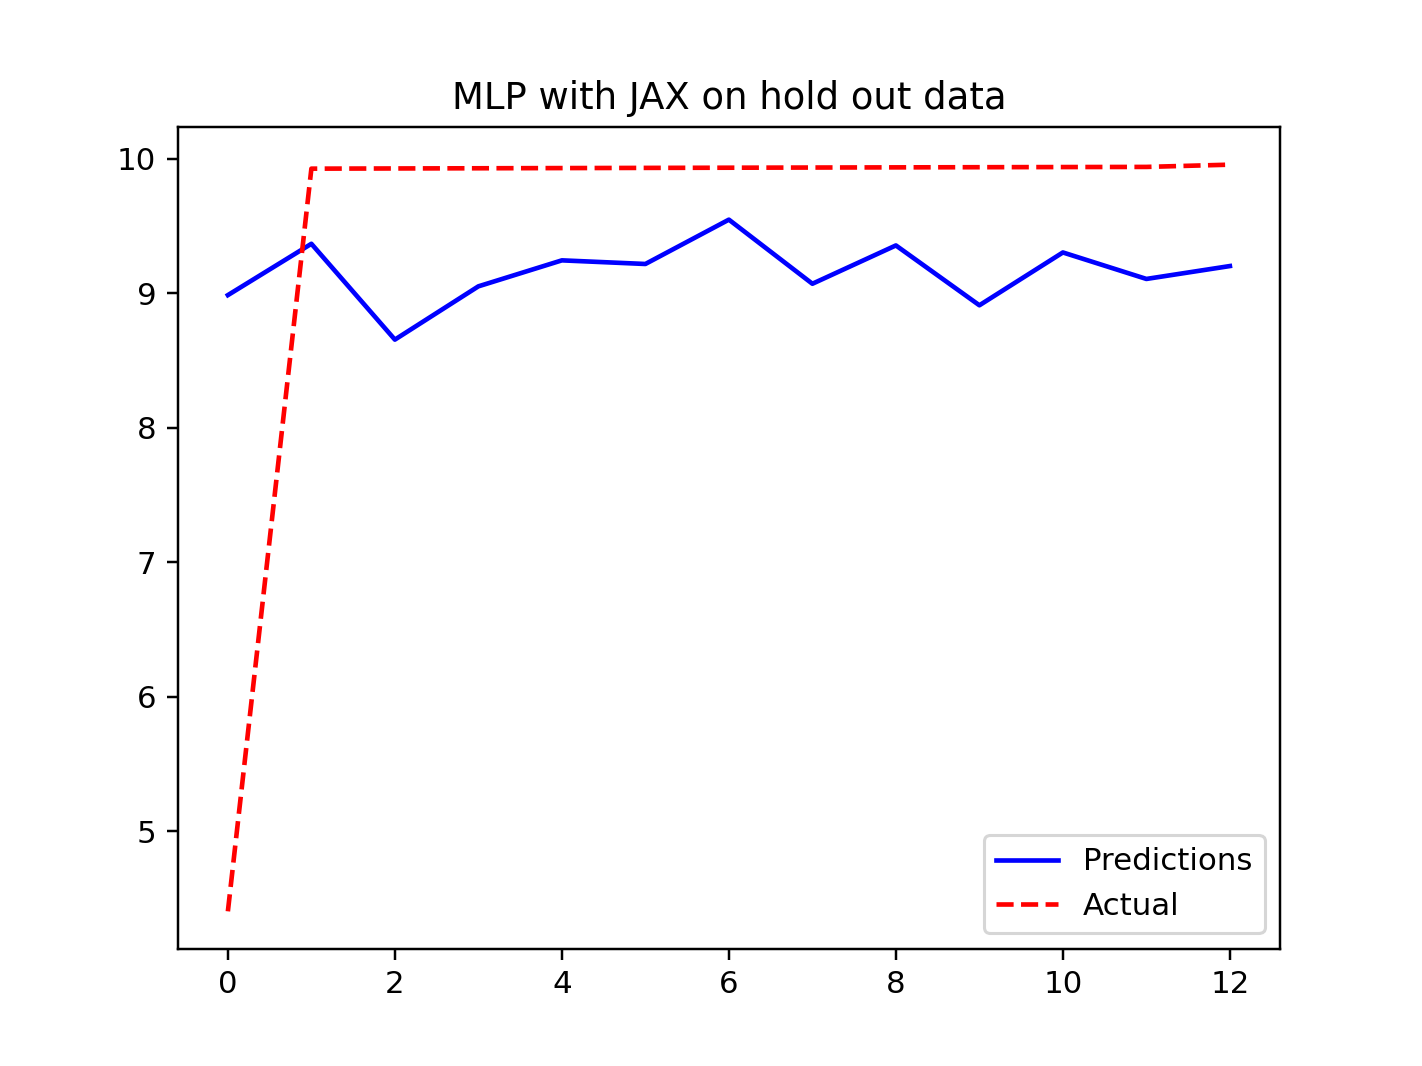

Text(0.5, 1.0, 'MLP with JAX on hold out data')

In [19]:
import torch.utils.data as data    

N = 10
q = 2
p = 3 + 3*N
traj_len = ref_traj.shape[0]

horizon = 11

num_iter = int(traj_len/horizon)

Tstart=0
Tend=traj_len


# ref_chunks = np.vstack([ref_traj[i*100+5:(i+1)*100-5, :] for i in range(0, len(ref_traj))])
# actual_chunks = np.vstack([actual_traj[i*101+5:(i+1)*101-6, :] for i in range(0, len(actual_traj))])

Kp = 5 * np.array([[2, 0, 0], [0, 1, 0]])
#key = jax.random.PRNGKey(793)
#Kd = 50 * jax.random.uniform(key=key, shape=(2, 3))

cost_traj, input_traj = compute_tracking_cost(ref_traj, actual_traj, rdot_traj, Kp, N, horizon, 1)

#aug_state = [np.append(actual_traj[r, :], ref_traj[r:r+N, :]) for r in range(len(ref_traj)-N)]
#aug_state = np.array(aug_state)

aug_test_state = []
for i in range(num_iter):
    aug_test_state.append(np.append(actual_traj[i*horizon, :], ref_traj[i*N:(i+1)*N, :]))
# aug_state = [np.append(actual_traj[r, :], ref_traj[r:r+N, :]) for r in range(num_iter)]
aug_test_state = np.array(aug_test_state)
print(aug_test_state.shape)

Tstart=0
Tend=aug_test_state.shape[0]

test_dataset = TrajDataset(aug_test_state[Tstart:Tend-1, :].astype('float64'), input_traj[Tstart:Tend-1, :].astype('float64'),
                               cost_traj[Tstart:Tend-1, None].astype('float64'), aug_test_state[Tstart+1:Tend, :].astype('float64'))
test_data_loader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=numpy_collate)
eval_model(trained_model_state, test_data_loader, batch_size)

data_input, _, cost, _ = next(iter(test_data_loader))
out = trained_model(data_input)  # No explicit parameter passing necessary anymore
plt.figure()
plt.plot(out.ravel(), 'b-', label="Predictions")
plt.plot(cost.ravel(), 'r--', label="Actual")
plt.legend()
plt.title("MLP with JAX on hold out data")

### Inference on the test data

In [21]:
out = []
true = []
for batch in test_data_loader:
    data_input, _, cost, _ = batch
    out.append(trained_model(data_input))
    true.append(cost)

In [22]:
out = np.vstack(out)
true = np.vstack(true)

<IPython.core.display.Javascript object>


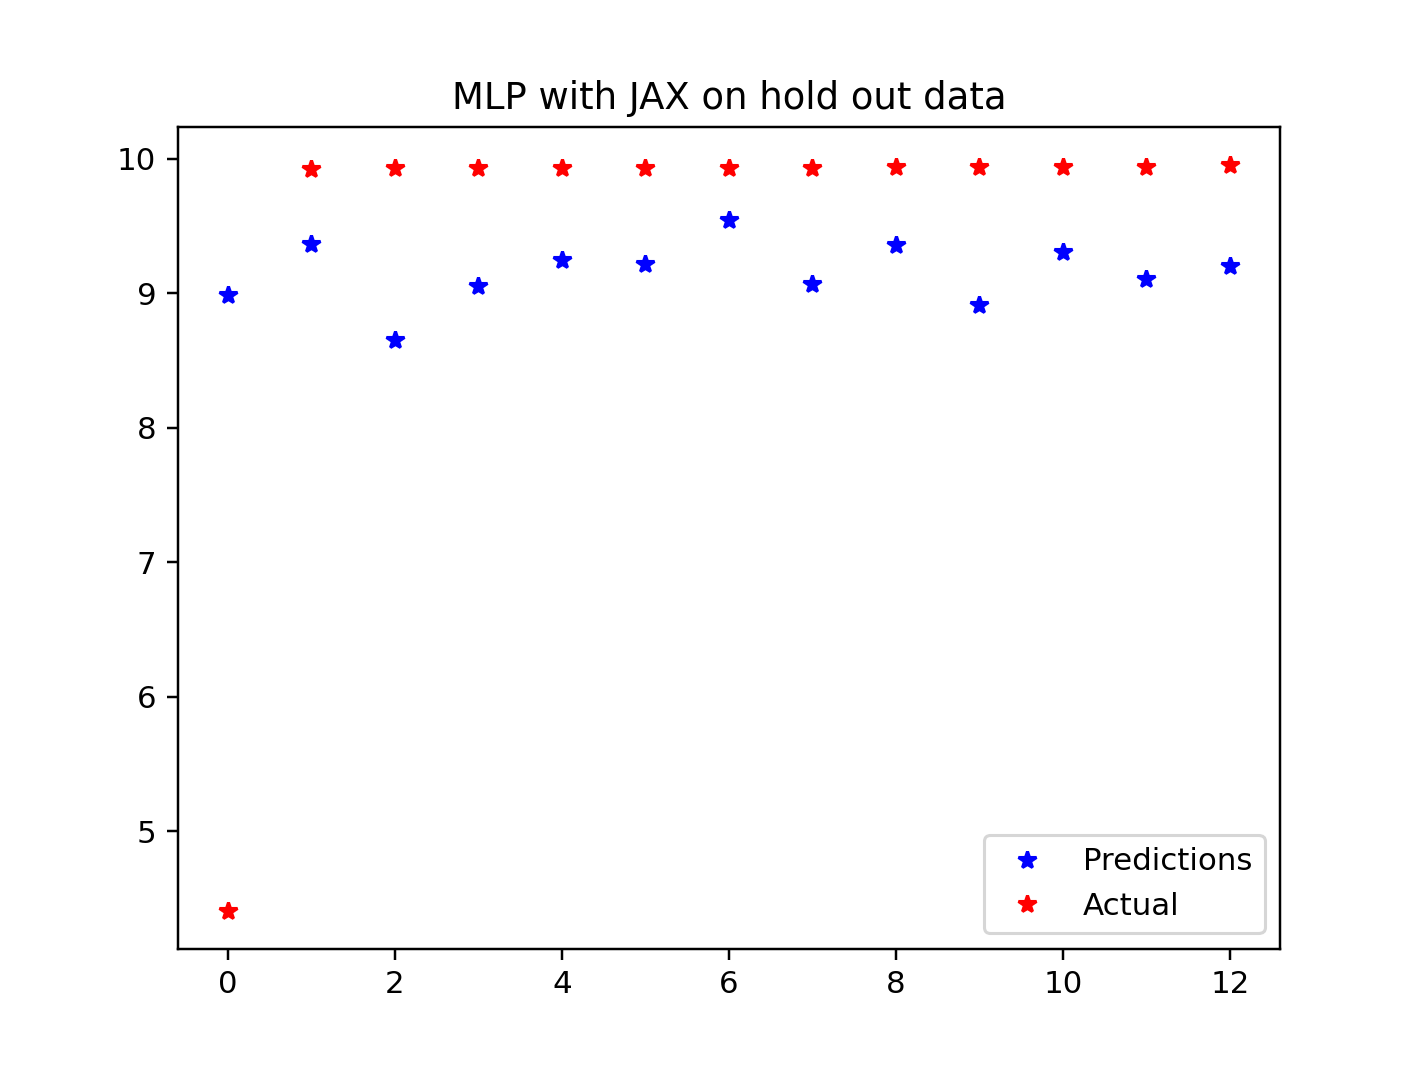

Text(0.5, 1.0, 'MLP with JAX on hold out data')

In [23]:
plt.figure()
plt.plot(out.ravel(), 'b*', label="Predictions")
plt.plot(true.ravel(), 'r*', label="Actual")
plt.legend()
plt.title("MLP with JAX on hold out data")

## Test time

### Optimize over the trajectories in the test dataset

In [22]:
from model_learning import test_model

data_state, _, data_cost, _ = next(iter(test_data_loader))
print(data_state[0])
print(data_cost[0])
jax_sol, solution, data = test_model(trained_model_state, test_data_loader, batch_size)

[0.37805867 0.48923445 0.36530539 0.37805867 0.48923445 0.36530539
 0.39246106 0.49571142 0.39740276 0.407924   0.50263041 0.42896724
 0.42431256 0.51022774 0.45989937 0.4414998  0.51866943 0.49013746]
[[0.00031462]]
Shape of data (18,)
Shape of data (18,)
Shape of data (18,)
Shape of data (18,)
Shape of data (18,)
Shape of data (18,)
Shape of data (18,)
Shape of data (18,)
Shape of data (18,)
Shape of data (18,)
Shape of data (18,)
Shape of data (18,)
Shape of data (18,)
Shape of data (18,)
Shape of data (18,)
Shape of data (18,)
Shape of data (18,)
Shape of data (18,)
Shape of data (18,)
Shape of data (18,)
Shape of data (18,)
Shape of data (18,)
Shape of data (18,)
Shape of data (18,)
Shape of data (18,)
Shape of data (18,)
Shape of data (18,)
Shape of data (18,)
Shape of data (18,)
Shape of data (18,)
Shape of data (18,)
Shape of data (18,)
Shape of data (18,)
Shape of data (18,)
Shape of data (18,)
Shape of data (18,)
Shape of data (18,)
Shape of data (18,)
Shape of data (18,)
Sha

0.0009838883
init [0.37805867 0.4892344  0.3653054 ]
New ref [[0.34881398 0.53944045 0.35161775]
 [0.39322126 0.51589435 0.40355456]
 [0.3987648  0.5241155  0.42568877]
 [0.43243688 0.50243056 0.47446144]
 [0.4414997  0.51866937 0.49013743]]
rollout [[0.37805867 0.48923439 0.36530539]
 [0.38328841 0.49123462 0.36836441]
 [0.3863669  0.49242286 0.36588845]
 [0.38895769 0.4934155  0.35959066]
 [0.38990976 0.49377341 0.3466539 ]]
0.0003635969
init [0.39269873 0.4951048  0.3973846 ]
New ref [[0.36043707 0.55147815 0.38197502]
 [0.40891787 0.52479744 0.4355461 ]
 [0.41425696 0.534247   0.45573315]
 [0.45113012 0.51003784 0.505769  ]
 [0.45936888 0.5280669  0.51964366]]
rollout [[0.39269873 0.49510479 0.39738461]
 [0.39810696 0.4973747  0.40069713]
 [0.40120088 0.49868533 0.39845411]
 [0.40378817 0.4997745  0.39264151]
 [0.40459399 0.50010823 0.38021691]]
0.0002441579
init [0.4082048  0.5019024  0.42890802]
New ref [[0.37271547 0.5647649  0.41143498]
 [0.42568898 0.5346217  0.46697402]
 [0.4

rollout [[1.07486844 1.26682723 1.05936134]
 [1.08323753 1.28173889 1.06977078]
 [1.08982811 1.29377353 1.07864828]
 [1.0957497  1.30481817 1.08864763]
 [1.10057975 1.31404736 1.0980721 ]]
0.000565552
init [1.0921553 1.2978076 1.0642712]
New ref [[1.0626061 1.347068  1.0481817]
 [1.1102357 1.3532177 1.0718715]
 [1.1217284 1.3867791 1.06604  ]
 [1.155432  1.3860931 1.0839281]
 [1.1590602 1.4239371 1.0773602]]
rollout [[1.09215534 1.29780757 1.06427121]
 [1.10060956 1.31304575 1.07470344]
 [1.10737546 1.32554649 1.08383835]
 [1.11346237 1.33704235 1.09410687]
 [1.11849483 1.34678744 1.10402042]]
0.00049888936
init [1.1093446 1.3289442 1.0685173]
New ref [[1.0817375 1.3742224 1.0540066]
 [1.1268401 1.3826929 1.0753417]
 [1.1389691 1.4160823 1.069873 ]
 [1.171146  1.4180071 1.0857518]
 [1.1760358 1.4553376 1.0790372]]
rollout [[1.1093446  1.32894421 1.06851733]
 [1.11788961 1.34450137 1.0789701 ]
 [1.12483374 1.35746321 1.08835819]
 [1.13108963 1.36940846 1.09889875]
 [1.13632567 1.3796680

<IPython.core.display.Javascript object>


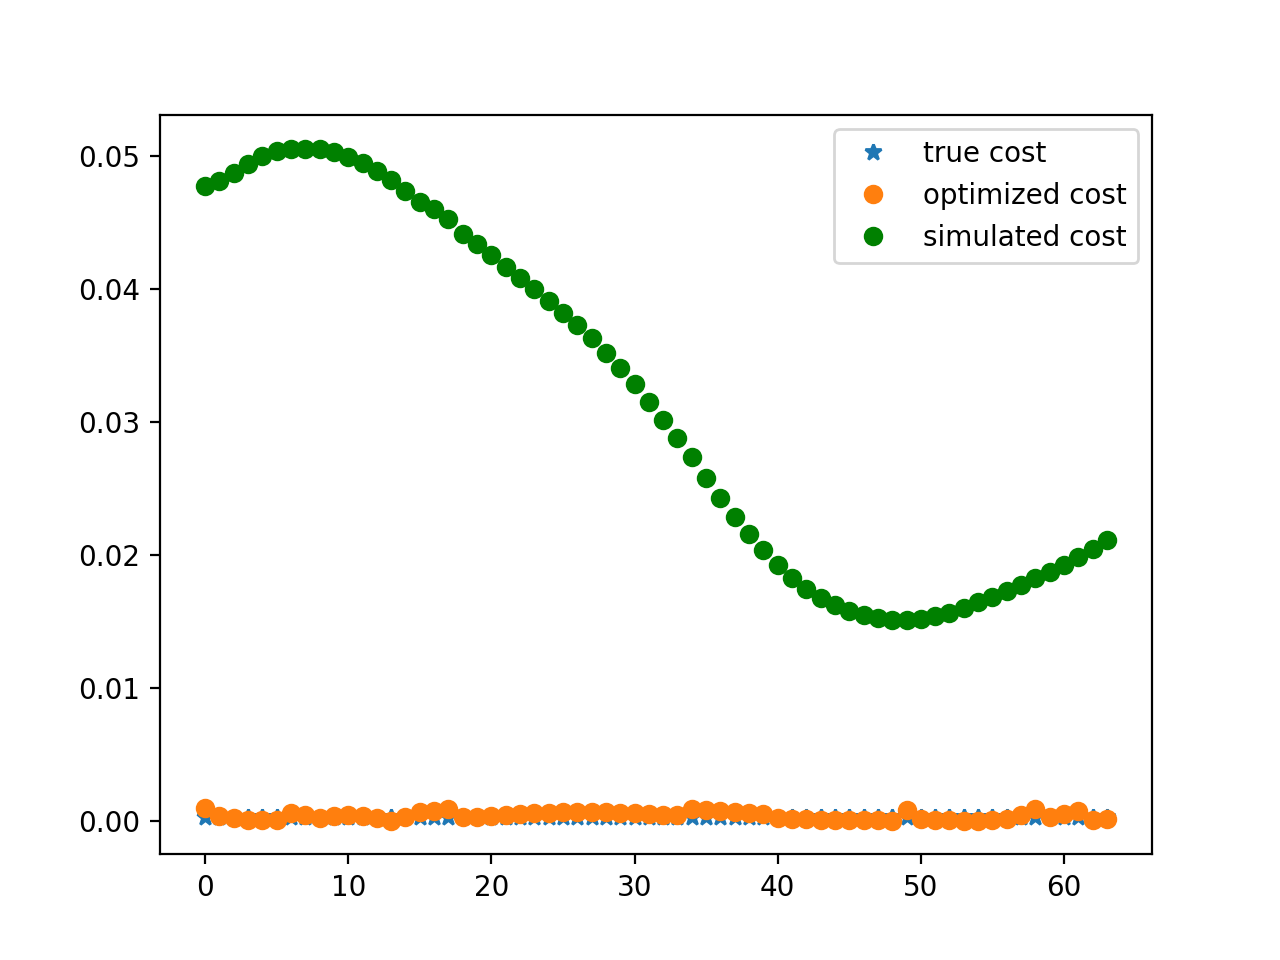

In [29]:
from generate_data import forward_simulate

cost = []
reg_cost = []
rollout = []
ref = []

i = 0
for sol in solution:
    # Take the augmented state -- init state + ref and simulate the unicycle -- compute cost and verify
    print(sol.state.error)
    reg_cost.append(sol.state.error)
    new_aug_state = sol.params
    x0 = new_aug_state[0:3]
    print("init", x0)
    ref.append(new_aug_state[3:].reshape([N, 3]))
    print("New ref", ref[i])
    # input
    c, x = forward_simulate(x0, ref[i], N)
    cost.append(c)
    rollout.append(x)
    print("rollout", x)
    i += 1
    
plt.figure()
plt.plot(data_cost.ravel(), '*', label="data cost")
plt.plot(reg_cost, 'o', label="optimized cost")
plt.plot(cost, 'og', label="simulated cost")
plt.legend()

In [41]:
ref = np.vstack(ref)
print(ref.shape)

(320, 3)


In [42]:
new_data = np.vstack(data)
print(new_data.shape)

(64, 18)


[ 1.4444368 -1.0257452  2.926608 ]
[0.80659175 0.3132937  2.14963436 0.80659175 0.31329373 0.
 0.81363493 0.3203437  0.         0.82083946 0.32745633 0.
 0.82820523 0.33463162 0.         0.8357324  0.34186959 0.        ]


Text(0, 0.5, 'y position')

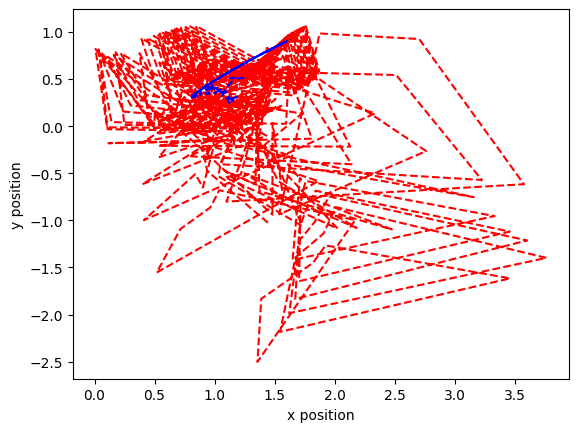

In [46]:
plt.figure()
m = 0
print(ref[m])
print(data[m])

plt.plot(ref[:, 0], ref[:, 1], 'r--')
plt.plot(new_data[:, 0::3], new_data[:, 1::3], 'b--')
plt.xlabel("x position")
plt.ylabel("y position")

## Evaluate on polynomial trajectories and ilqr


In [27]:
from generate_data import generate_polynomial_trajectory
import numpy as np
import jax.numpy as jnp

num_inf = 100

inits = np.random.uniform(0, 1, (2, num_inf))
inits = np.append(inits, np.zeros(num_inf))
inits = np.reshape(inits, (3, num_inf))

goals = np.random.uniform(0.2, 1.2, (2, num_inf))
goals = np.append(goals, np.zeros(num_inf))
goals = np.reshape(goals, (3, num_inf))

N = 10

# uni_ilqr1 = ILQR(unicycle, maxiter=1000)

poly_traj = []
for i in range(num_inf):
    poly_traj.append(generate_polynomial_trajectory(inits[:, i], goals[:, i], N, 2))
    # ilqr_traj.append()
    
print(poly_traj[0].shape)

poly_aug_state = [np.append(poly_traj[r][0, :], poly_traj[r]) for r in range(len(poly_traj))]
poly_aug_state = jnp.array(poly_aug_state)
print(poly_aug_state.shape)

(10, 3)
(100, 33)


In [92]:
from model_learning import gradient_descent, calculate_cost, gradient_descent_with_line_search
from jax.scipy.optimize import minimize
from jaxopt import LBFGS
from jaxopt import ProjectedGradient
from jaxopt.projection import projection_affine_set
import numpy as np
from functools import partial
import jax.numpy as jnp

def calc_cost_GD(ref):
    pred = trained_model_state.apply_fn(trained_model_state.params, ref).ravel()
    return jnp.exp(pred[0])

pg = ProjectedGradient(calc_cost_GD, projection=projection_affine_set)
A = np.zeros((6, (N+1)*3))
A[0, 0] = 1
A[1, 1] = 1
A[2, 2] = 1
A[-3, -3] = 1
A[-2, -2] = 1
A[-1, -1] = 1

#pg_sol = pg.run(w_init, data=(X, y)).params

solution = []
solution2 = []
for i in range(10):
    #solution.append(gradient_descent(calculate_cost, poly_aug_state[i, :3], poly_aug_state[i, -3:], 
    #                trained_model_state, trained_model_state.params, poly_aug_state[i, 3:]))
    # GD = LBFGS(calculate_cost)
    #solution2.append(GD.run(poly_aug_state[i, 3:], poly_aug_state[i, :3], poly_aug_state[i, -3:], 
    #                trained_model_state, trained_model_state.params))
    
    init = poly_aug_state[i, 0:3]
    goal = poly_aug_state[i, -3:]
    b = np.append(init, goal)
    solution2.append(pg.run(poly_aug_state[i, :], hyperparams_proj=(A, b)))
    
    #solution2.append(gradient_descent_with_line_search(calculate_cost, poly_aug_state[i, 3:], poly_aug_state[i, :3], 
    #                            poly_aug_state[i, -3:], trained_model_state, trained_model_state.params))
    
    # solution2.append(minimize(calculate_cost, poly_aug_state[i, 3:], 
    #    args=(poly_aug_state[i, :3], poly_aug_state[i, -3:], trained_model_state, trained_model_state.params), method="BFGS"))
    

NameError: name 'poly_aug_state' is not defined

In [24]:
from model_learning import gradient_descent, calculate_cost, gradient_descent_with_line_search
from jax.scipy.optimize import minimize
from jaxopt import LBFGS
from jaxopt import ProjectedGradient
from jaxopt.projection import projection_affine_set
import numpy as np
from functools import partial
import jax.numpy as jnp

def calc_cost_GD(init_ref, ref):
    pred = trained_model_state.apply_fn(trained_model_state.params, ref).ravel()
    return 10e-4 *jnp.exp(pred[0]) + jnp.linalg.norm(init_ref - ref) ** 2 


A = np.zeros((6, (N+1)*3))
A[0, 0] = 1
A[1, 1] = 1
A[2, 2] = 1
A[-3, -3] = 1
A[-2, -2] = 1
A[-1, -1] = 1

#pg_sol = pg.run(w_init, data=(X, y)).params

solution = []
solution2 = []
for i in range(7):
    #solution.append(gradient_descent(calculate_cost, poly_aug_state[i, :3], poly_aug_state[i, -3:], 
    #                trained_model_state, trained_model_state.params, poly_aug_state[i, 3:]))
    # GD = LBFGS(calculate_cost)
    #solution2.append(GD.run(poly_aug_state[i, 3:], poly_aug_state[i, :3], poly_aug_state[i, -3:], 
    #                trained_model_state, trained_model_state.params))
    
    init = aug_test_state[i, 0:3]
    goal = aug_test_state[i, -3:]
    
    print(init)
    print(goal)
    b = np.append(init, goal)
    
    init_ref = aug_test_state[i, :].copy()
    
    pg = ProjectedGradient(partial(calc_cost_GD, init_ref), projection=projection_affine_set, maxiter=20)
    solution2.append(pg.run(aug_test_state[i, :], hyperparams_proj=(A, b)))
    
    
    
    #solution2.append(gradient_descent_with_line_search(calculate_cost, poly_aug_state[i, 3:], poly_aug_state[i, :3], 
    #                            poly_aug_state[i, -3:], trained_model_state, trained_model_state.params))
    
    # solution2.append(minimize(calculate_cost, poly_aug_state[i, 3:], 
    #    args=(poly_aug_state[i, :3], poly_aug_state[i, -3:], trained_model_state, trained_model_state.params), method="BFGS"))
    

[0.01216197 1.19935727 2.91190672]
[2.12098813 2.42922211 0.25150976]
[0.01216197 1.19935727 2.91190672]
[1.70734525 2.682055   2.53918266]
[0.93144321 0.45903587 0.73453975]
[1.85800231 1.02460063 0.3197313 ]
[0.93144321 0.45903587 0.73453975]
[1.62169695 0.80381453 0.62876606]
[0.45849657 1.56607699 0.76147133]
[0.87501937 1.72476637 0.162687  ]
[0.45849657 1.56607699 0.76147133]
[0.68136972 1.68937325 0.68836999]
[1.50712609 1.61579537 1.19562089]
[1.42739785 1.48422587 0.67337918]


In [25]:
print(solution2[0].params)

[ 0.01216197  1.1993572   2.9119062  -0.07126978  1.4367552   2.9535184
  0.42147204  1.196415    2.3967855   0.7317085   0.6657741   2.1511822
  0.4834664   0.96745497  1.396465    0.15854493  1.1012546   1.017809
  0.62789273  1.4473563   0.7125933   0.88274735  1.6797093   0.921253
  1.2991593   2.302219    0.5996216   1.7627449   2.7107687   0.20785177
  2.1209881   2.4292216   0.25150973]


<IPython.core.display.Javascript object>


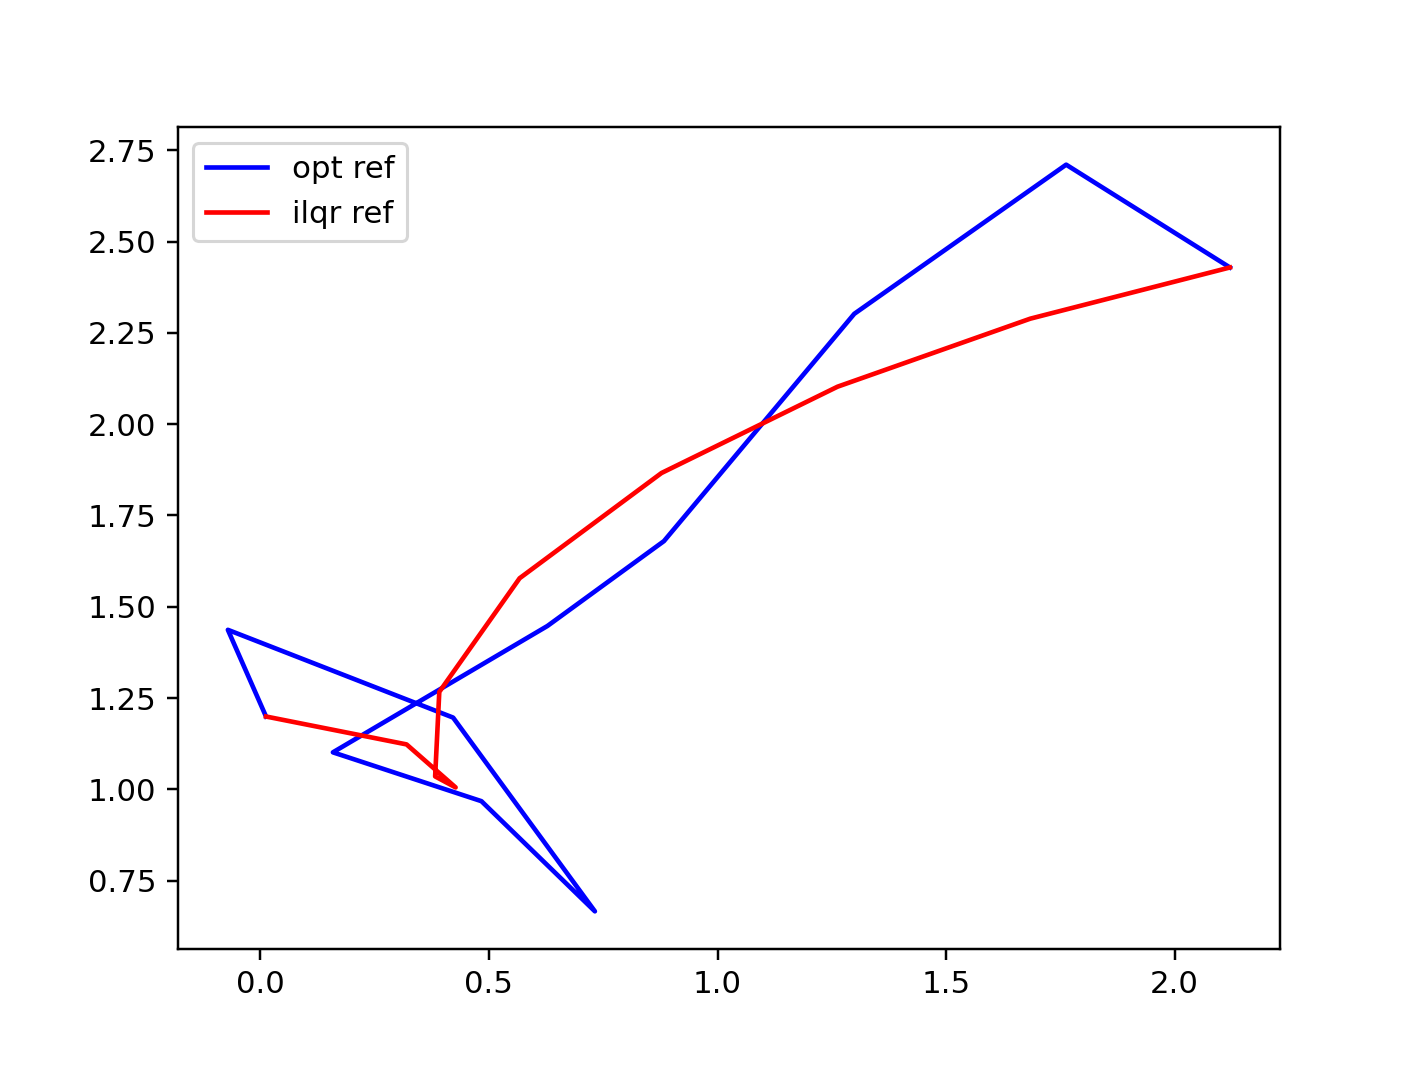

In [26]:
plt.figure()

for i in range(1):
    plt.plot(solution2[i].params[0::3], solution2[i].params[1::3], 'b-', label='opt ref')
    #plt.plot(ref[i][:, 0], ref[i][:, 1], 'g-', label='opt2')
    #plt.plot(poly_traj[i][:, 0], poly_traj[i][:, 1], 'r--')
    plt.plot(aug_test_state[i, 0::3], aug_test_state[i, 1::3], 'r-', label='ilqr ref')
    plt.legend()

38.768629608940124
35.32092060526713
63.15176926866855
14.027115166970393
30.871649356789078
14.973771520049791
12.017303662613072
29.875879884185448
nan
33.63503


<IPython.core.display.Javascript object>


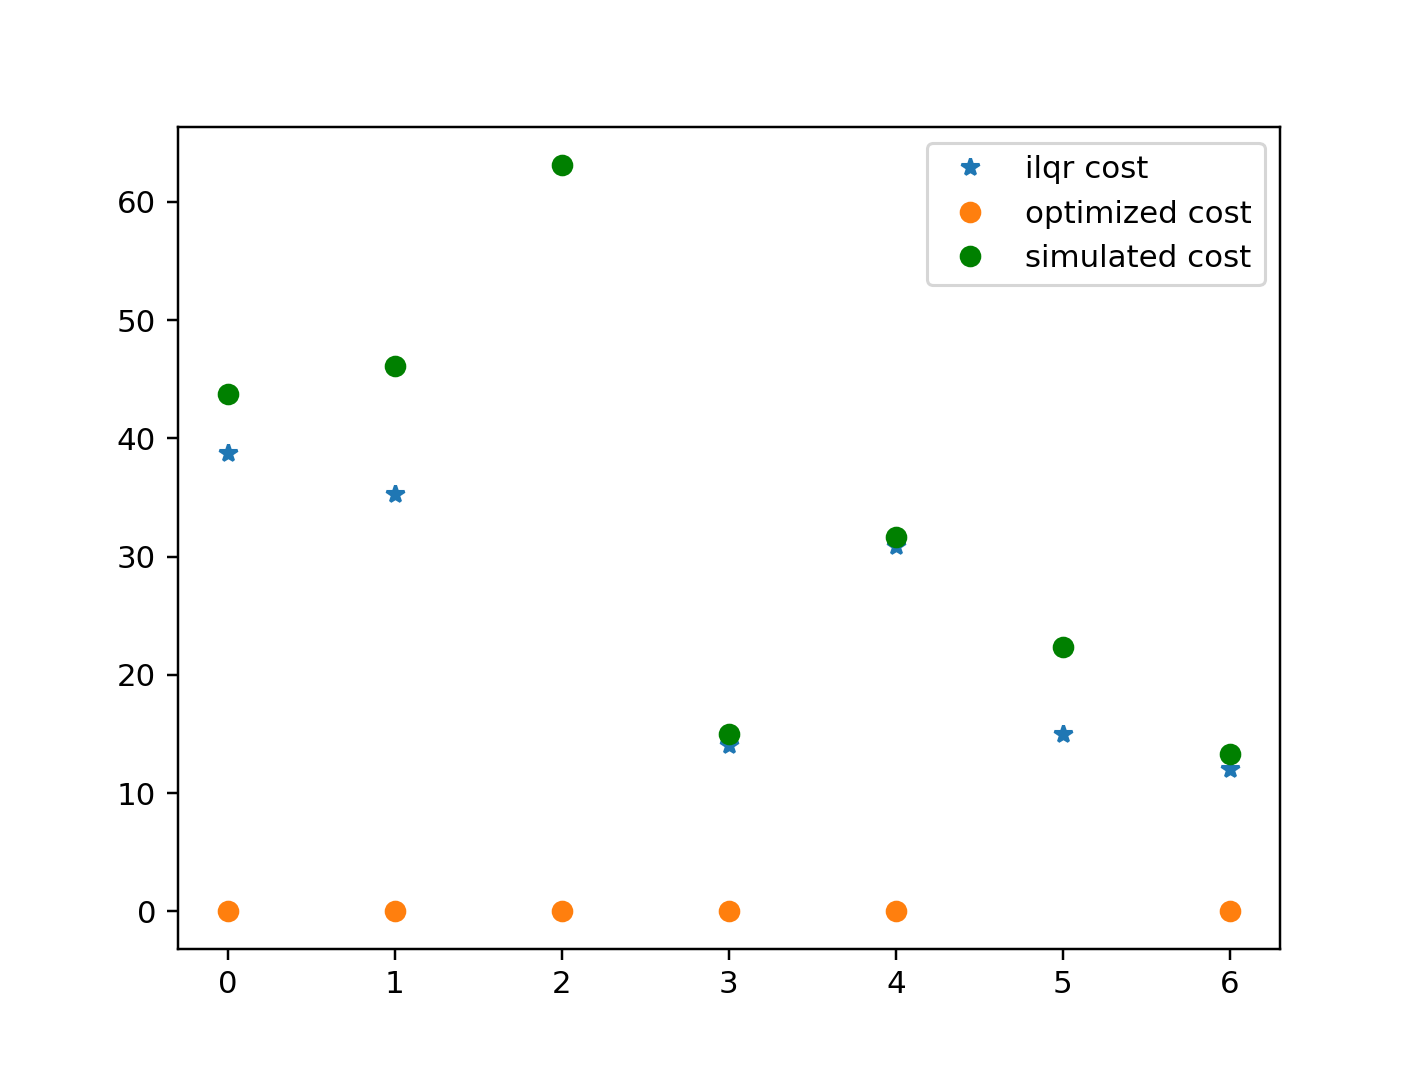

In [27]:
from generate_data import forward_simulate

sim_cost = []
ilqr_cost = []
reg_cost = []
rollout = []
ref = []

N=10

i = 0
for sol in solution2:
    #print(sol)
    # Take the augmented state -- init state + ref and simulate the unicycle -- compute cost and verify
    reg_cost.append(sol.state.error)
    # print(reg_cost)
    new_aug_state = sol.params
    x0 = new_aug_state[0:3]
    #print("init", x0)
    ref.append(new_aug_state[3:].reshape([N, 3]))
    #print("New ref", ref[i])
    # input
    c, x = forward_simulate(x0, ref[i], N)
    sim_cost.append(c)
    rollout.append(x)
    x0 = aug_test_state[i, 0:3]
    ci, xi = forward_simulate(x0, aug_test_state[i, 3:].reshape([N,3]), N)
    #c_ilqr = np.exp(cost_traj[i][0])
    print(ci)
    ilqr_cost.append(ci)
    #c_poly, x_poly = forward_simulate(x0, poly_traj[i], N)
    #poly_cost.append(c_poly)
    #print("rollout", x)
    i += 1
    

print(np.mean(ilqr_cost))
print(np.mean(reg_cost))
print(np.mean(sim_cost))
plt.figure()
plt.plot(ilqr_cost, '*', label="ilqr cost")
plt.plot(reg_cost, 'o', label="optimized cost")
plt.plot(sim_cost, 'og', label="simulated cost")
plt.legend()

In [26]:
from generate_data import forward_simulate

sim_cost = []
poly_cost = []
reg_cost = []
rollout = []
ref = []

i = 0
for sol in solution2:
    #print(sol)
    # Take the augmented state -- init state + ref and simulate the unicycle -- compute cost and verify
    reg_cost.append(sol.state.error)
    new_aug_state = sol.params
    x0 = new_aug_state[0:3]
    #print("init", x0)
    ref.append(new_aug_state[3:].reshape([N, 3]))
    #print("New ref", ref[i])
    # input
    c, x = forward_simulate(x0, ref[i], N)
    sim_cost.append(c)
    rollout.append(x)
    c_poly, x_poly = forward_simulate(x0, poly_traj[i], N)
    poly_cost.append(c_poly)
    #print("rollout", x)
    i += 1
    

print(np.mean(poly_cost))
print(np.mean(reg_cost))
print(np.mean(sim_cost))
plt.figure()
plt.plot(poly_cost, '*', label="true cost")
plt.plot(reg_cost, 'o', label="optimized cost")
plt.plot(sim_cost, 'og', label="simulated cost")
plt.legend()

NameError: name 'poly_traj' is not defined

In [45]:
print(solution)

[DeviceArray([0.9895245 , 0.99761105, 0.15315244, 1.270803  , 1.0573907 ,
             0.104464  , 1.7374961 , 1.2314272 , 0.1505105 , 2.2875876 ,
             1.5148616 , 0.15788655, 2.9540257 , 1.9813128 , 0.16022299],            dtype=float32), DeviceArray([-3.1133296e-04,  1.8872030e-02, -4.5619380e-02,
              2.7006650e-01,  5.1453817e-01, -3.3984169e-02,
              4.9745101e-01,  1.0048804e+00, -4.3190714e-02,
              7.4614954e-01,  1.4898112e+00, -4.4955004e-02,
              9.8835266e-01,  1.9894595e+00, -5.2838802e-02],            dtype=float32), DeviceArray([ 0.01108708,  0.00850977, -0.00886909,  0.5239247 ,
              0.25481218, -0.00639153,  1.0011003 ,  0.5001019 ,
             -0.00863023,  1.4918234 ,  0.7409198 , -0.0088453 ,
              1.9817169 ,  0.99424696, -0.00900054], dtype=float32)]


In [75]:
from generate_data import forward_simulate

cost = []
rollout = []
poly_cost = []
poly_rollout = []
ref = []

for i in range(3): 
    x0 = poly_traj[i][0, :]
    print("init", x0)
    goal = poly_traj[i][-1, :]
    print("goal", goal)
    new_aug_state = np.append(x0, solution[i][3:-3])
    new_aug_state = np.append(new_aug_state, goal)
    ref.append(new_aug_state.reshape([N, 3]))
    
    print("New ref", ref[i])
    c, x = forward_simulate(x0, ref[i], N)
    c_poly, x_poly = forward_simulate(x0, poly_traj[i], N)
    cost.append(c)
    poly_cost.append(c_poly)
    rollout.append(x)
    poly_rollout.append(x_poly)
    print("rollout", x)
    
print("Poly", np.mean(poly_cost))
print("Opt", np.mean(cost))
    
plt.figure()
plt.plot(poly_cost, '*', label="poly traj cost")
plt.plot(cost, 'o', label="optimized traj cost")
plt.legend()

init [-7.88915315e-16  1.00000000e+00  0.00000000e+00]
goal [2. 2. 0.]


IndexError: list index out of range

In [38]:
from model_learning import calculate_cost
from jax.scipy.optimize import minimize

solution = []
for i in range(3):
    solution.append(minimize(calculate_cost, poly_aug_state[i, 3:], 
        args=(poly_aug_state[i, :3], poly_aug_state[i, -3:], trained_model_state, trained_model_state.params), method="BFGS"))
    

In [43]:
# How to parse the solution at test time?
# from helper_functions import forward_simulate

cost = []
reg_cost = []
rollout = []
ref = []

i = 0
for sol in solution:
    # Take the augmented state -- init state + ref and simulate the unicycle -- compute cost and verify
    reg_cost.append(sol.fun)
    new_aug_state = sol.x
    x0 = new_aug_state[0:3]
    print("init", x0)
    ref.append(new_aug_state.reshape([N, 3]))
    print("New ref", ref[i])
    # input
    c, x = forward_simulate(x0, ref[i], Kp, Kd, N)
    cost.append(c)
    rollout.append(x)
    print("rollout", x)
    i += 1
    
plt.figure()
plt.plot(data_cost.ravel(), '*', label="true cost")
plt.plot(reg_cost, 'o', label="optimized cost")
plt.legend()

AttributeError: 'DeviceArray' object has no attribute 'fun'

<IPython.core.display.Javascript object>


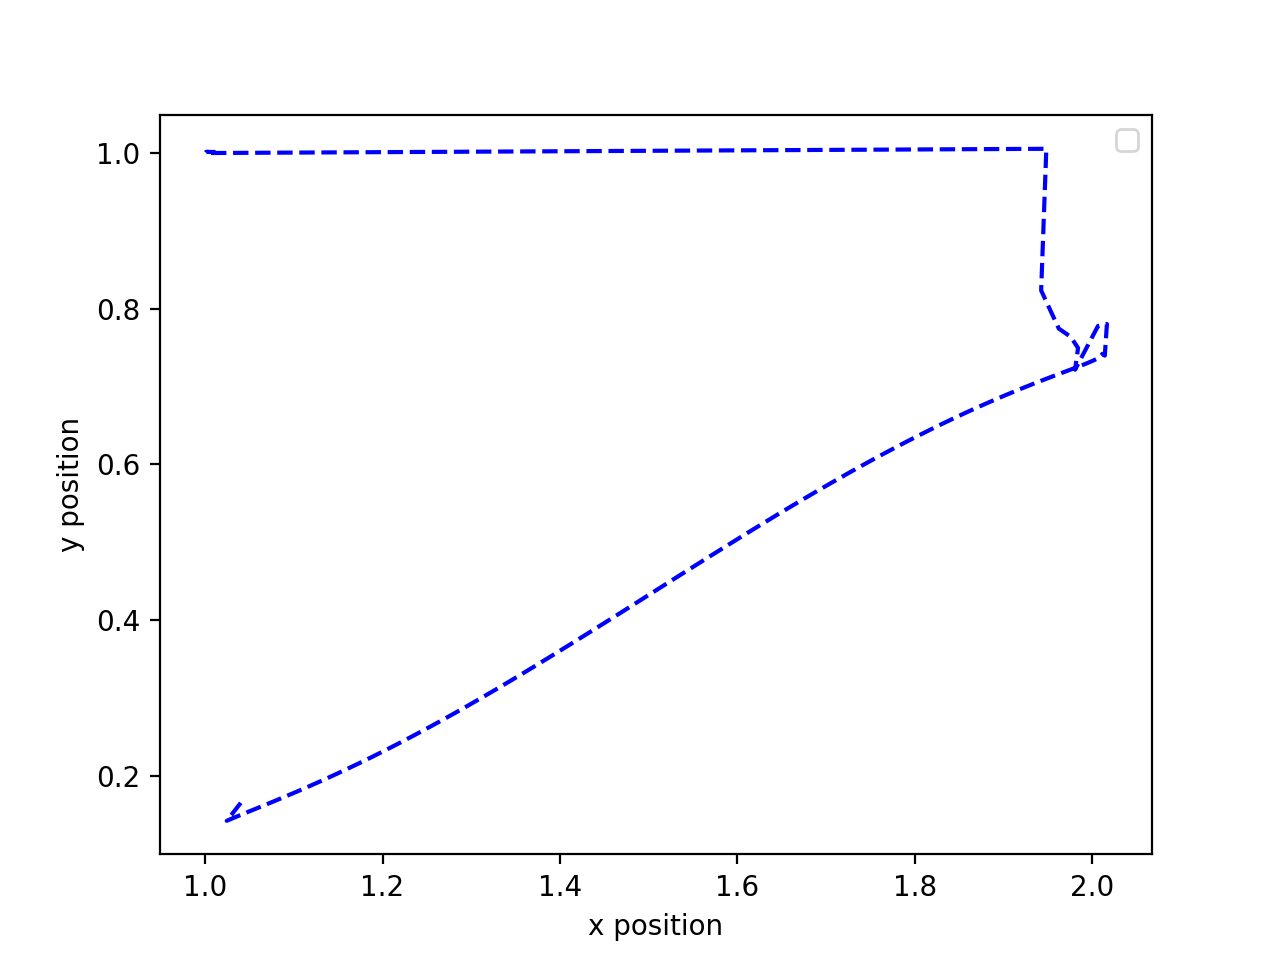

[[nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan 

In [39]:
plt.figure()
m = 0
print(ref[m])
print(data[m])
# plt.plot(ref[0:10, 0], ref[0:10, 1], 'r--', label="new ref")
plt.plot(new_data[0, 0::3], new_data[0, 1::3], 'b--')
plt.xlabel("x position")
plt.ylabel("y position")
plt.legend()

In [ ]:
print(solution[0].fun)
print(solution[0].x)

In [23]:
import jax.numpy as np
from jax import grad, jit
from functools import partial


def line_search(func, params, grad_func, direction, alpha=0.1, beta=0.5, max_iters=100):
    # Initialize step size as 1
    t = 1.0

    # Perform line search
    for i in range(max_iters):
        # Evaluate the function and gradient at the current parameters
        f = func(params)
        grad_f = grad_func(params)

        # Update parameters in the search direction
        next_params = params + t * direction

        return np.where(func(next_params) <= f + alpha * t * jnp.dot(grad_f, direction), t, beta * t)


def gradient_descent_with_line_search(func, init_params, learning_rate=0.01, num_iters=100):
    # Define the gradient of the function using JAX's `grad` function
    grad_func = grad(func)

    # Define a JIT-compiled version of the gradient descent update step
    #@partial(jit, static_argnums=[0])
    @jit
    def update(params):
        gradient = grad_func(params)
        direction = -gradient
        step_size = line_search(func, params, grad_func, direction)
        # step_size = 1
        return params + step_size * direction

    # Perform gradient descent by iteratively updating the parameters
    params = init_params
    for i in range(num_iters):
        params = update(params)
    
    return params

# Example usage
def my_func(params):
    return np.sum(params ** 2)

init_params = np.array([1.0, 2.0])
optimized_params = gradient_descent_with_line_search(my_func, init_params)
print(optimized_params)


[0. 0.]


In [82]:
import jax.numpy as jnp
from jax import grad
from jaxopt import projection
from jaxopt import optimizers

def projected_gradient_descent(func, init_params, projection_fn, step_size=0.01, num_iters=100):
    # Define the gradient of the function using JAX's `grad` function
    grad_func = grad(func)

    # Define the `opt_init` and `opt_update` functions using the `optimizers` module
    opt_init, opt_update, get_params = optimizers.sgd(step_size=step_size)
    
    # Initialize the optimizer state using `opt_init`
    opt_state = opt_init(init_params)

    # Perform projected gradient descent by iteratively updating the parameters
    for i in range(num_iters):
        # Get the current parameters from the optimizer state using `get_params`
        params = get_params(opt_state)

        # Compute the gradient of the function at the current parameters
        grad_params = grad_func(params)

        # Project the gradient onto the feasible set using the projection function
        grad_params_proj = projection_fn(params, grad_params)

        # Update the optimizer state using `opt_update`
        opt_state = opt_update(i, grad_params_proj, opt_state)

    # Return the optimized parameters
    return get_params(opt_state)

# Example usage
def my_func(params):
    return jnp.sum(params**2)

init_params = jnp.array([1.0, 2.0])
projected_params = projection.box(np.asarray([-1.0, -1.0]), np.asarray([1.0, 1.0]))
optimized_params = projected_gradient_descent(my_func, init_params, projected_params)
print(optimized_params)


ImportError: cannot import name 'optimizers' from 'jaxopt' (/home/anusha/.local/lib/python3.8/site-packages/jaxopt/__init__.py)

## Visualization plots code

In [ ]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame(np.dstack([out, cost]).reshape([64, 2]), columns=['preds', 'actual'])

order=['preds', 'actual']
x = "Evaluation on Training"
y = "Tracking Cost"
#print(pd.melt(df))
flierprops = dict(marker='o', markerfacecolor='#FFFFFF', markersize=4,
                  linestyle='none', markeredgecolor='#D3D3D3')
plt.figure()
axes = sns.boxplot(data=pd.melt(df, var_name=x, value_name=y), x=x, y=y, order=order, dodge=False, width=0.5, medianprops=dict(color='black'), 
                     # palette={labels[0]:"blue", labels[1]:"orange", labels[2]:"green", labels[3]:"red"}, saturation=1,
                      flierprops=flierprops,
                      showmeans=True, meanprops={"marker":"*", "markerfacecolor":"black", "markeredgecolor":"black"})
axes.set_xlabel(x, fontsize=15)
axes.set_ylabel(y, fontsize=15)
axes.set_ylim((0, 10))
# plt.savefig('/home/anusha/Downloads/icra_results/train.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

data_input, _, cost, _ = next(iter(train_data_loader))
out = trained_model(data_input)  # No explicit parameter passing necessary anymore
plt.figure()
plt.plot(out.ravel(), 'o', label="Predictions")
plt.plot(cost.ravel(), 'o', label="Actual")
plt.legend()
plt.title("MLP with JAX on training data")

In [ ]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame(np.dstack([np.vstack(out), np.vstack(true)]).reshape([499, 2]), columns=['preds', 'actual'])

order=['preds', 'actual']
x = "Evaluation on Hold Out Data"
y = "Tracking Cost"
#print(pd.melt(df))
flierprops = dict(marker='o', markerfacecolor='#FFFFFF', markersize=4,
                  linestyle='none', markeredgecolor='#D3D3D3')
plt.figure()
axes = sns.boxplot(data=pd.melt(df, var_name=x, value_name=y), x=x, y=y, order=order, dodge=False, width=0.5, medianprops=dict(color='black'), 
                     # palette={labels[0]:"blue", labels[1]:"orange", labels[2]:"green", labels[3]:"red"}, saturation=1,
                      flierprops=flierprops,
                      showmeans=True, meanprops={"marker":"*", "markerfacecolor":"black", "markeredgecolor":"black"})
axes.set_xlabel(x, fontsize=15)
axes.set_ylabel(y, fontsize=15)
axes.set_ylim((0, 10))
# plt.savefig('/home/anusha/Downloads/icra_results/train.png', dpi=300, bbox_inches='tight')
plt.show()

[33.05322928987819, 30.745585735703976, 52.3875809740762, 51.790265282162785, 30.486091092464335, 38.73040974582933, 52.255606002506255, 36.634944894787, 43.022917723568995, 57.31951043003703]


<IPython.core.display.Javascript object>


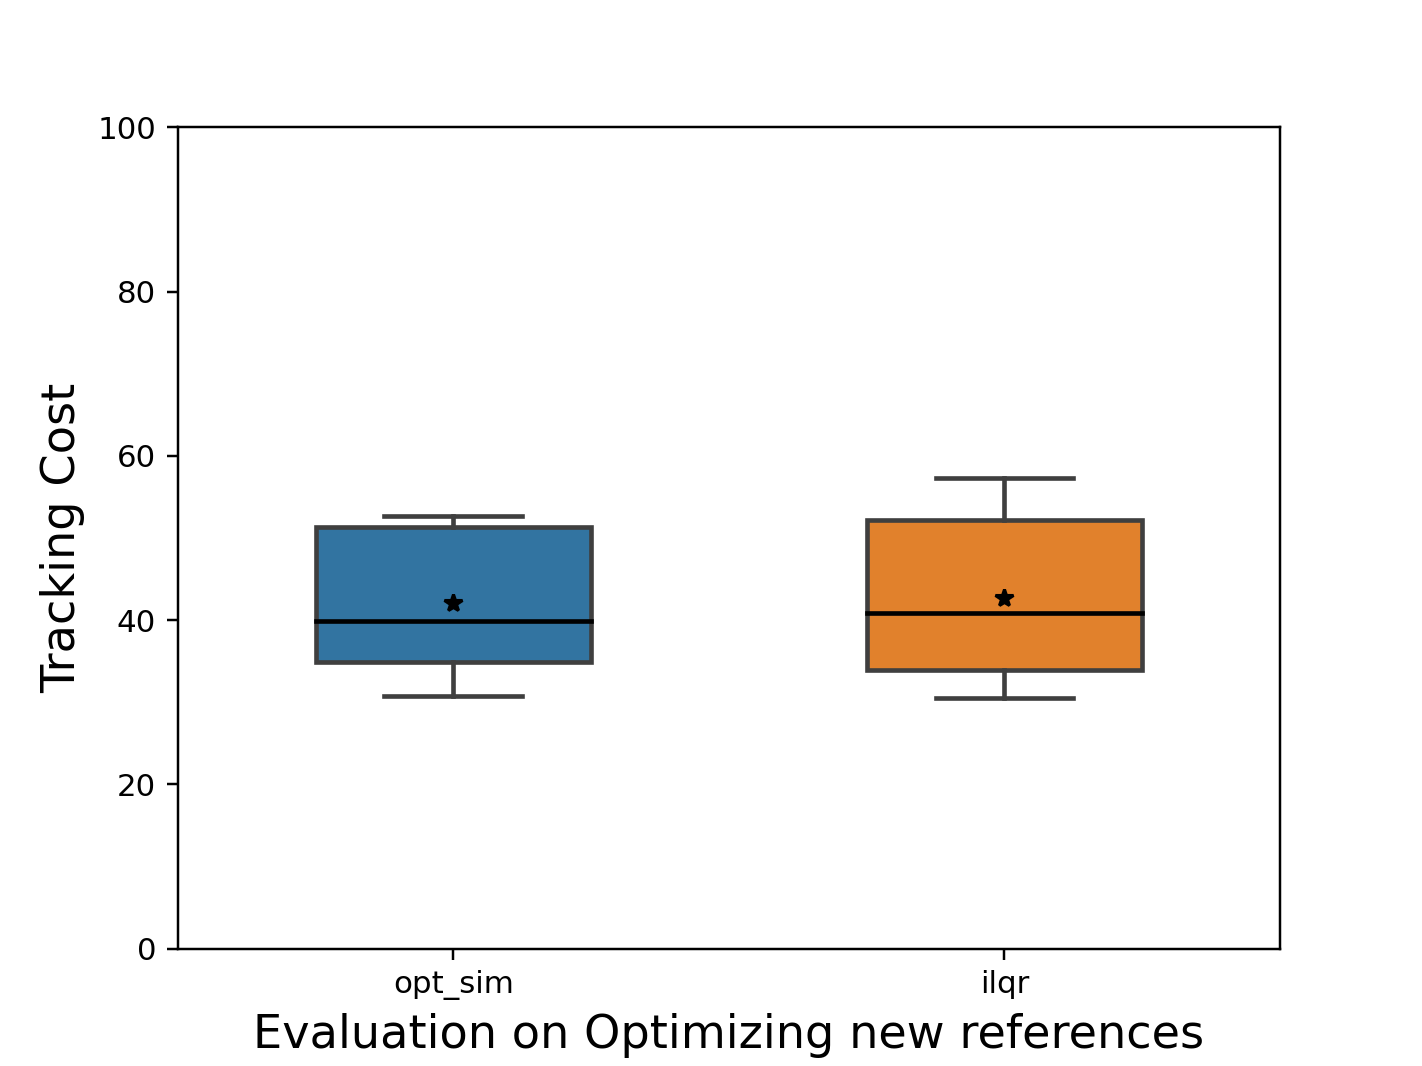

In [97]:
import pandas as pd
import seaborn as sns

#print(sim_cost)
print(ilqr_cost)

df = pd.DataFrame(np.dstack([sim_cost, ilqr_cost]).reshape([10, 2]), columns=['opt_sim', 'ilqr'])

order=['opt_sim', 'ilqr']
x = "Evaluation on Optimizing new references"
y = "Tracking Cost"
#print(pd.melt(df))
flierprops = dict(marker='o', markerfacecolor='#FFFFFF', markersize=4,
                  linestyle='none', markeredgecolor='#D3D3D3')
plt.figure()
axes = sns.boxplot(data=pd.melt(df, var_name=x, value_name=y), x=x, y=y, order=order, dodge=False, width=0.5, medianprops=dict(color='black'), 
                     # palette={labels[0]:"blue", labels[1]:"orange", labels[2]:"green", labels[3]:"red"}, saturation=1,
                      flierprops=flierprops,
                      showmeans=True, meanprops={"marker":"*", "markerfacecolor":"black", "markeredgecolor":"black"})
axes.set_xlabel(x, fontsize=15)
axes.set_ylabel(y, fontsize=15)
axes.set_ylim((0, 100))
# plt.savefig('/home/anusha/Downloads/icra_results/train.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
df = pd.DataFrame(np.dstack(traj_costs).reshape([10, 2]), columns=['0.1', '10'])

order=['0.1', '10']
x = "Tracking Penalty (rho)"
y = "Tracking Cost"
#print(pd.melt(df))
flierprops = dict(marker='o', markerfacecolor='#FFFFFF', markersize=4,
                  linestyle='none', markeredgecolor='#D3D3D3')
axes = sns.boxplot(data=pd.melt(df, var_name=x, value_name=y), x=x, y=y, order=order, dodge=False, width=0.5, medianprops=dict(color='black'), 
                     # palette={labels[0]:"blue", labels[1]:"orange", labels[2]:"green", labels[3]:"red"}, saturation=1,
                      flierprops=flierprops,
                      showmeans=True, meanprops={"marker":"*", "markerfacecolor":"black", "markeredgecolor":"black"})
axes.set_xlabel(x, fontsize=15)
axes.set_ylabel(y, fontsize=15)
#axes.set_ylim((7, 9))
plt.savefig('/home/anusha/Downloads/icra_results/cost-rho-results.png', dpi=300, bbox_inches='tight')
plt.show()